In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install python-igraph

In [ ]:
! pip install louvain

In [ ]:
! pip install scanpy

In [ ]:
! pip install matplotlib==3.1.3

In [ ]:
!pip install anndata

In [ ]:
! pip install biopython bcbio-GFF

In [ ]:
!pip install mnnpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import mnnpy

In [ ]:
count_files = ["/content/drive/MyDrive/scPanBetaT2D-master/input_files/%s" %f for f in ["SEG_counts.tsv","XIN_counts.tsv","LAW_counts.tsv"]]
metadata_files = ["/content/drive/MyDrive/scPanBetaT2D-master/input_files/%s" %f for f in ["SEG_metadata.sdrf","XIN_metadata.sdrf","LAW_metadata.sdrf"]]
mitochondrial_annotation = "/content/drive/MyDrive/scPanBetaT2D-master/input_files/ensembl/mitochondrial_genes.txt"

In [ ]:
def sampleName2Pnumber(sampleName,d):
    import re
    c = "C" + re.split("[_-]",sampleName)[0][:-2]
    return d.get(c,"NA")

def getMetadataSEG(sdrf,colsToUse=['Characteristics[individual]',
                                         'Comment[ENA_RUN]',
                                         'Characteristics[single cell well quality]',
                                         'Characteristics[cell type]',
                                         'Characteristics[disease]',
                                         'Characteristics[sex]',
                                         'Characteristics[age]',
                                         'Characteristics[body mass index]'],
                         index_col='Comment[ENA_RUN]'):
    """ retrieve information associated with each cell from a sdrf file """
    return pd.read_table(sdrf,sep='\t',usecols=colsToUse,index_col=index_col,squeeze=True)




def getMetadataXIN(sra):
    colsToUse = ["Run","Age","cell_subtype","Condition","donor_id","Ethnicity","gender"]
    df = pd.read_csv(sra ,usecols=colsToUse)
    return df


metadataSEG = getMetadataSEG(metadata_files[0])
metadataXIN = getMetadataXIN(metadata_files[1])

In [ ]:
metadataXIN.head()

,Run,Age,cell_subtype,Condition,donor_id,Ethnicity,gender
0,SRR3541303,23,beta,non-diabetic,Non T2D 1,AA,male
1,SRR3541304,23,beta,non-diabetic,Non T2D 1,AA,male
2,SRR3541305,23,beta,non-diabetic,Non T2D 1,AA,male
3,SRR3541306,23,beta,non-diabetic,Non T2D 1,AA,male
4,SRR3541308,23,beta,non-diabetic,Non T2D 1,AA,male


In [ ]:
metadataSEG.head()

,Characteristics[individual],Characteristics[single cell well quality],Characteristics[cell type],Characteristics[disease],Characteristics[sex],Characteristics[age],Characteristics[body mass index]
Comment[ENA_RUN],,,,,,,
ERR1630013,AZ,low quality cell,not applicable,normal,male,43,30.8
ERR1630014,AZ,OK,delta cell,normal,male,43,30.8
ERR1630015,AZ,OK,alpha cell,normal,male,43,30.8
ERR1630016,AZ,OK,delta cell,normal,male,43,30.8
ERR1630017,AZ,OK,gamma cell,normal,male,43,30.8


In [ ]:
def countTable2Adata(countTable,metadata,skipSTARInfos=False,toKeepOnlyIds=None,sep=" "):
    """ create a `Adata` object, from STAR count table and sdrf infos, computing all
    necessary QC metrics (number of genes, read counts, mitochondrial fraction).
    - countTable: count table obtained merging the output of STAR (with --quantMode GeneCounts)
                  obtained for each cell
    - metadata: dataframe with metadata information
    - skipSTARInfos: specify if first four lines (with additional info from STAR) should be skipped
    - toKeepOnlyIds: file with cell IDs that should be kept (the others will be excluded)
    - sep: character used to separate fields
    """
    count_df = pd.read_table(countTable,index_col=0,header=0,engine="python",sep=sep)
    ## get X (value matrix)
    if skipSTARInfos: X = count_df.T.apply(pd.to_numeric)
    else: X = count_df.iloc[4:,:].T.apply(pd.to_numeric)
    if toKeepOnlyIds != None:
        with open(toKeepOnlyIds) as fh:
            toKeepOnlyIds_ = {l.strip() for l in fh}
        X = X[X.index.isin(toKeepOnlyIds_)]
    ## get obs df
    obs_idxs = count_df.columns
    obs = metadata
    if "Characteristics[individual]" in obs.columns:
        obs.columns = map(lambda x: x.replace("Characteristics[","").replace("]",""),
                          obs.columns.values)
    obs.index.name = None
    obs.reindex(obs_idxs)
    # add STAR infos
    if not skipSTARInfos:
        for r in ["N_unmapped","N_multimapping","N_noFeature","N_ambiguous"]:
            obs[r] = count_df.loc[r,]
    X.index = obs.index
    # get var df
    if skipSTARInfos: var = pd.DataFrame(index=count_df.index)
    else: var = pd.DataFrame(index=count_df.index[4:])
    # make adata and add mapping QC infos
    adata = ad.AnnData(X,obs=obs,var=var)
    return adata

ad_seg = countTable2Adata(count_files[0],metadataSEG)
ad_xin = countTable2Adata(count_files[1],metadataXIN,
                          skipSTARInfos=True,sep="\t")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
ad_seg

AnnData object with n_obs × n_vars = 3514 × 57905
    obs: 'individual', 'single cell well quality', 'cell type', 'disease', 'sex', 'age', 'body mass index', 'N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous'

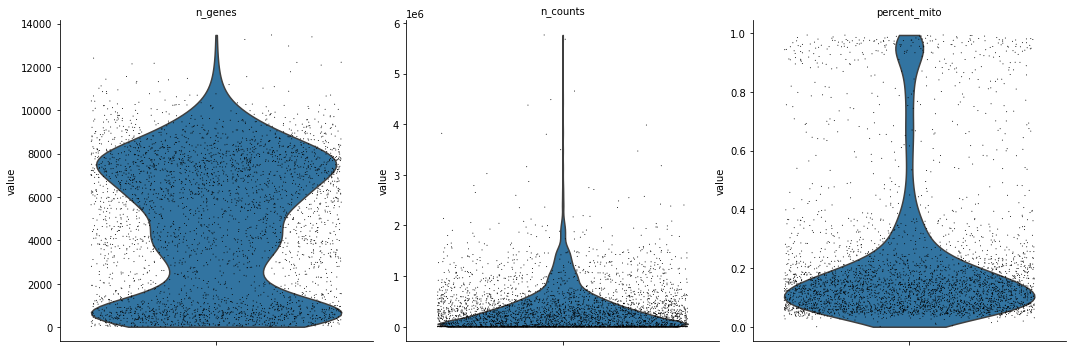

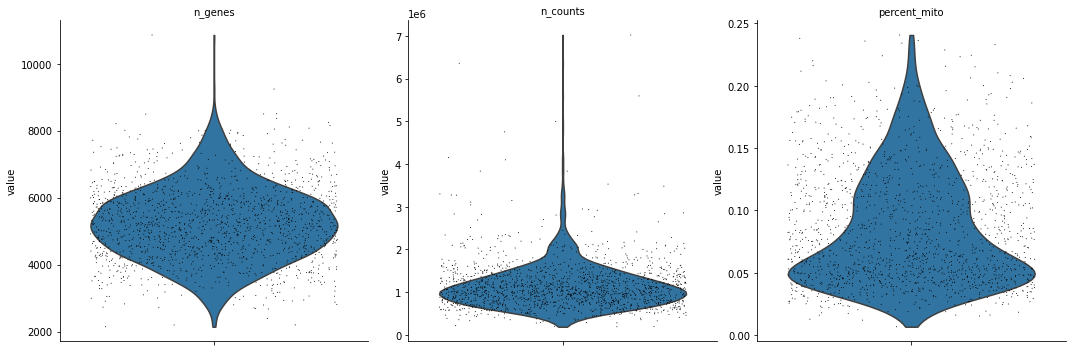

In [ ]:
def get_n_genes(adata):
    """ return number of genes with at least 1 mapping read """
    return (adata.X>0).sum(axis=1)

def get_n_counts(adata,genes_subset=None):
    """ return number of reads mapped to genes """
    if genes_subset == None: return np.sum(adata.X,axis=1)
    return np.sum(adata[:,genes_subset].X,axis=1)

def get_percent_mito(adata,mitochondrial_genes=None):
    """ return fraction of reads mapped to mitochondrial genes """
    if mitochondrial_genes == None: 
        mitochondrial_genes = [i.strip()
                               for i in open("/content/drive/MyDrive/scPanBetaT2D-master/input_files/ensembl/mitochondrial_genes.txt")]
    mito_count,all_count = get_n_counts(adata,mitochondrial_genes),get_n_counts(adata)
    return mito_count/all_count

def addQC2Adata(adata):
    """ compute the following QC metrics and add them to `adata`:
        - number of genes
        - total read count
        - fraction of reads mapping on mitochondrial genes """

    n_genes,n_counts,percent_mito = map(lambda x: x(adata),
                                        [get_n_genes,get_n_counts,get_percent_mito])
    for label,value in zip(("n_genes","n_counts","percent_mito"),
                           (n_genes,n_counts,percent_mito)):
        adata.obs[label] = value

for adata in [ad_seg,ad_xin]:
    addQC2Adata(adata)
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4,multi_panel=True,show=False)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


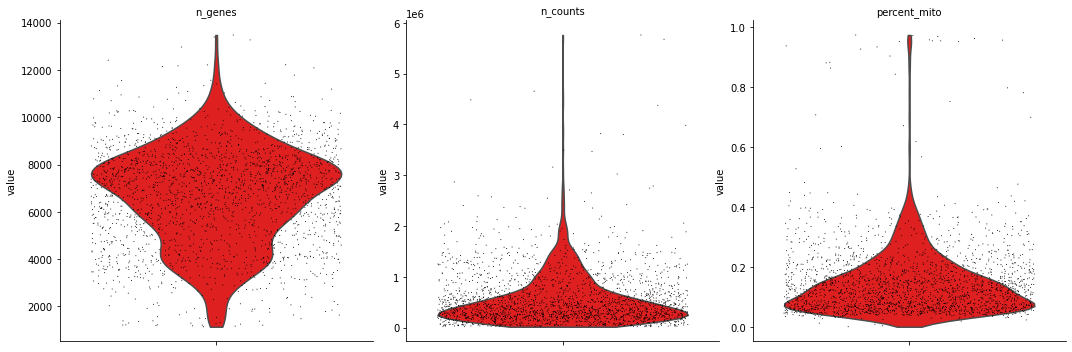

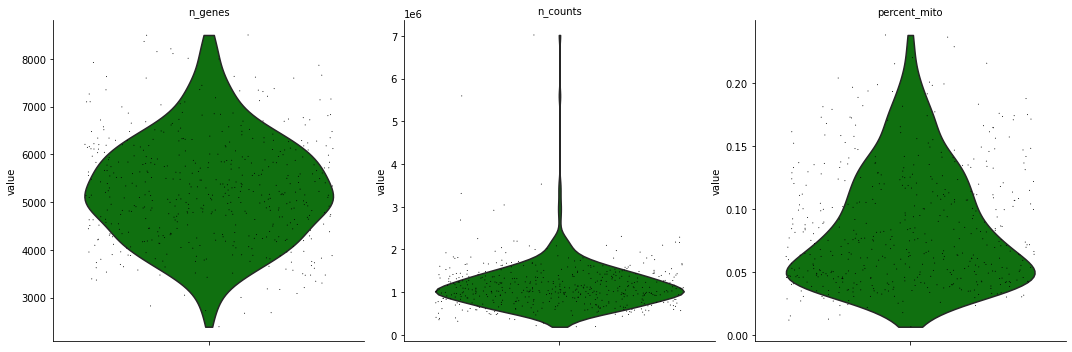

In [ ]:
def getOKdata(adata,min_cells=3):
    """ SEG metadata has indicate with `OK` cells with high quality """
    oks = adata[adata.obs["single cell well quality"]=="OK",]
    sc.pp.filter_genes(oks, min_cells=min_cells)
    return oks

def getBetadata(adata,min_cells=3):
    oks = adata[adata.obs["cell_subtype"]=="beta",]
    sc.pp.filter_genes(oks, min_cells=min_cells)
    return oks

ad_seg = getOKdata(ad_seg)
ad_xin = getBetadata(ad_xin)

for adata,col in zip([ad_seg,ad_xin],["red","green"]):
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4,multi_panel=True,color=col)

In [ ]:
#sc.pl.scatter(ad_law, 'n_counts', 'n_genes', color='percent_mito')
def addNullPoint(ad):
    """ add a null point with mit. fraction = 1 to uniform scales across dataframes """
    return ad.obs.append({'percent_mito' : 1,'n_counts':0, 'n_genes':0},
                         ignore_index=True)

def jointPlot(ad,xlim=None,ylim=None,hist_col=None,magnitude="K",palette="viridis",title=""):
    df = addNullPoint(ad)
    if xlim!=None: df = df[df['n_counts']<xlim]
    df = df[df['percent_mito']<=1]
    grid = sns.JointGrid(x='n_counts', y='n_genes', data=df)
    g = grid.plot_joint(sns.scatterplot, hue='percent_mito', data=df,palette=palette, linewidth=0,alpha=0.8)
    ax_x = sns.distplot(df['n_counts'], ax=g.ax_marg_x,color=hist_col)
    ax_y = sns.distplot(df['n_genes'], ax=g.ax_marg_y, vertical=True,color=hist_col)
    ax_x.set(xlabel='', ylabel='')
    ax_y.set(xlabel='', ylabel='')
    g.set_axis_labels(xlabel='Read counts',ylabel='Number of genes')
    if xlim==None: g.ax_marg_x.set_xlim(0,g.ax_marg_x.get_xlim()[1])
    else: g.ax_marg_x.set_xlim(0,xlim)
    #g.ax_marg_x.set_xlim(0,150000)
    if ylim==None: g.ax_marg_y.set_ylim(0,g.ax_marg_y.get_ylim()[1])
    else: g.ax_marg_y.set_ylim(0,ylim)
    #g.ax_marg_y.set_ylim(0,10000)
    if magnitude == "K": mag_n = 1000.
    else: mag_n = 1000000.
    xlabels = ['{:.1f}'.format(x) + magnitude for x in g.ax_joint.get_xticks()/mag_n]
    g.ax_joint.set_xticklabels(xlabels)
    new_labels = ["0-0.25","0.25-0.50","0.50-0.75","0.75-1"]
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles[1:], labels=new_labels,title="Mit. fraction")
    g.fig.suptitle(title)
    #print(legend.texts)
    #leg.texts
    return g

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distr

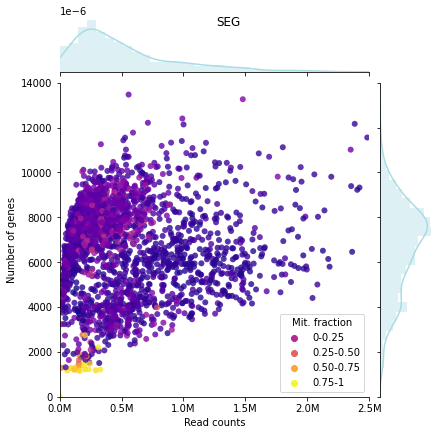

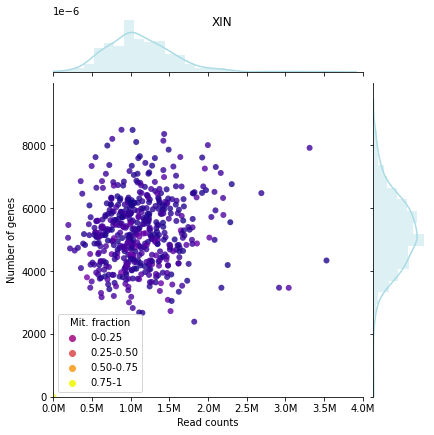

In [ ]:
g1 = jointPlot(ad_seg,magnitude="M",title="SEG",
               xlim=2500000,ylim=14000,
               hist_col="#ABDBE5",palette="plasma")
#plt.savefig("/content/drive/MyDrive/scPanBetaT2D-master/plots/jointPlot.SEG.pdf", transparent=True)

g2 = jointPlot(ad_xin,magnitude="M",palette="plasma",
               xlim=4000000,title="XIN",
               hist_col="#ABDBE5")
#plt.savefig("/content/drive/MyDrive/scPanBetaT2D-master/plots/jointPlot.XIN.pdf", transparent=True)



In [ ]:
def filterData(adata,
               min_genes=2000,
               max_genes=10000,
               min_counts=100000,
               max_counts=1000000,
               mito_fract=0.2,
               min_cells=3,
               report=False):
    """ filter data basing on QC thresholds """
    filtered = adata[(adata.obs["percent_mito"]<=mito_fract),]
    for k,v in {"min_genes":min_genes,  "max_genes":max_genes,
                "min_counts":min_counts, "max_counts":max_counts}.items():
        kwargs = {k:v}
    
        sc.pp.filter_cells(filtered,**kwargs)
    sc.pp.filter_genes(filtered, min_cells=min_cells)
    if report:
        before = adata.obs["cell type"].value_counts()
        print("""
        before filtering: 
                - %s cells (%s OK, %s low quality, %s others)
                - %s genes""" %(getCountReport(adata))) 
        print("""
        after filtering:
                - %s cells (%s OK, %s low quality, %s others)
                - %s genes""" %(getCountReport(filtered)))
    return filtered

# apply chosen filters
ad_seg_filt = filterData(ad_seg,
               min_genes=1500,
               max_genes=8000,
               min_counts=200000,
               max_counts=1000000,
               mito_fract=0.4)
ad_xin_filt = filterData(ad_xin,
               min_genes=1500,
               max_genes=6000,
               min_counts=400000,
               max_counts=1200000)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


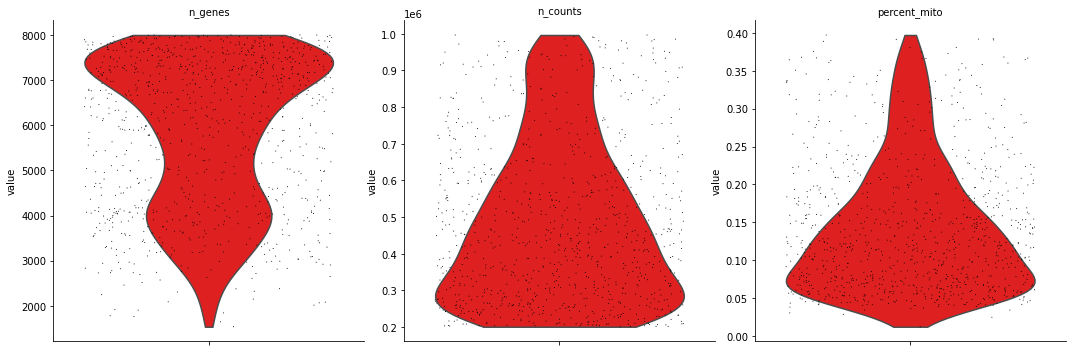

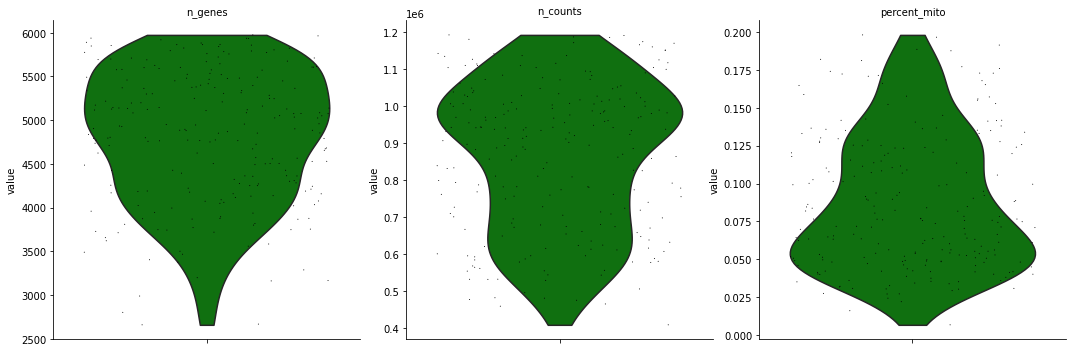

In [ ]:
filtered_ads = [ad_seg_filt,ad_xin_filt]
colors = ["red","green"]
for adata,col in zip(filtered_ads,colors):
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito',],
                 jitter=0.4,multi_panel=True,color=col)

In [ ]:
filtered_genes = []
for ad_ in filtered_ads:
    filtered_genes.append(set(ad_.var.index))

Text(0.5, 1.0, 'Distribution of `Number of cells` in which the genes to-be-removed are expressed')

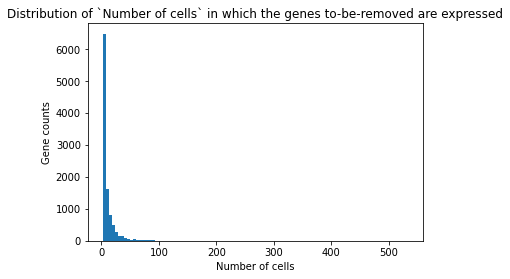

In [ ]:
further_filtering = {}
shared = set.intersection(*filtered_genes)
for i,s in enumerate(filtered_genes):
    #others = filtered_genes[:i] + filtered_genes[i+1:]
    uniq = s.difference(shared)
    #missing_in_others = s.difference(*others)
    further_filtering.update(filtered_ads[i].var["n_cells"][list(uniq)].to_dict())
plt.hist(further_filtering.values(),bins=100)
plt.xlabel('Number of cells')
plt.ylabel('Gene counts')
plt.title('Distribution of `Number of cells` in which the genes to-be-removed are expressed')

In [ ]:
ad_seg_final = ad_seg_filt[:,~ad_seg_filt.var.index.isin(further_filtering)]
ad_xin_final = ad_xin_filt[:,~ad_xin_filt.var.index.isin(further_filtering)]
ads_final = [ad_seg_final,ad_xin_final]

for dsname,ad_ in zip(["SEG","XIN"],ads_final):
    ad_.obs['dataset'] = [dsname]*ad_.n_obs
adata_final = ads_final[0].concatenate(ads_final[1:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


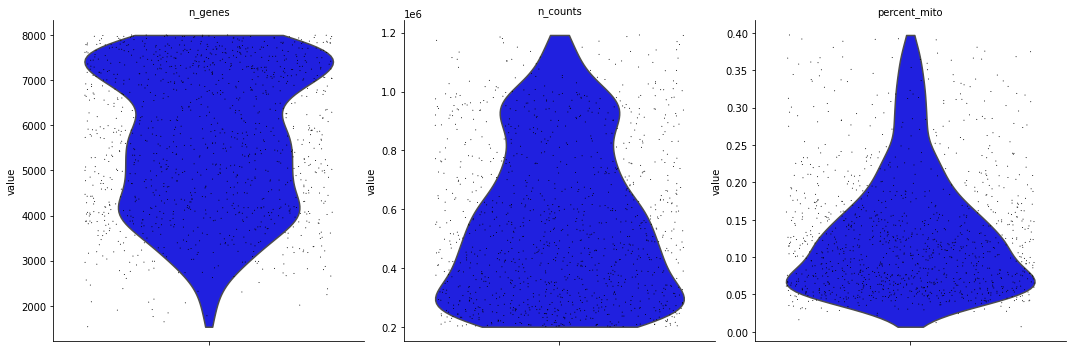

In [ ]:
filtered_ads = [adata_final]
colors = ["blue"]
for adata,col in zip(filtered_ads,colors):
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4,multi_panel=True,color=col)

In [ ]:
def addNullPoint2(ad):
    """ add a null point with mit. fraction = 1 to uniform scales across dataframes """
    return ad.obs.append({'percent_mito' : 1,'n_counts':0, 'n_genes':0},
                         ignore_index=True)

def jointPlot2(ad,xlim=None,ylim=None,hist_col=None,magnitude="K",palette="viridis",title=""):
    df = addNullPoint2(ad)
    if xlim!=None: df = df[df['n_counts']<xlim]
    df = df[df['percent_mito']<=1]
    grid = sns.JointGrid(x='n_counts', y='n_genes', data=df)
    g = grid.plot_joint(sns.scatterplot, hue='percent_mito', data=df,palette=palette, linewidth=0,alpha=0.8)
    ax_x = sns.distplot(df['n_counts'], ax=g.ax_marg_x,color=hist_col)
    ax_y = sns.distplot(df['n_genes'], ax=g.ax_marg_y, vertical=True,color=hist_col)
    ax_x.set(xlabel='', ylabel='')
    ax_y.set(xlabel='', ylabel='')
    g.set_axis_labels(xlabel='Read counts',ylabel='Number of genes')
    if xlim==None: g.ax_marg_x.set_xlim(0,g.ax_marg_x.get_xlim()[1])
    else: g.ax_marg_x.set_xlim(0,xlim)
    #g.ax_marg_x.set_xlim(0,150000)
    if ylim==None: g.ax_marg_y.set_ylim(0,g.ax_marg_y.get_ylim()[1])
    else: g.ax_marg_y.set_ylim(0,ylim)
    #g.ax_marg_y.set_ylim(0,10000)
    if magnitude == "K": mag_n = 1000.
    else: mag_n = 1000000.
    xlabels = ['{:.1f}'.format(x) + magnitude for x in g.ax_joint.get_xticks()/mag_n]
    g.ax_joint.set_xticklabels(xlabels)
    new_labels = ["0-0.25","0.25-0.50","0.50-0.75","0.75-1"]
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles[1:], labels=new_labels,title="Mit. fraction")
    g.fig.suptitle(title)
    #print(legend.texts)
    #leg.texts
    return g

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distr

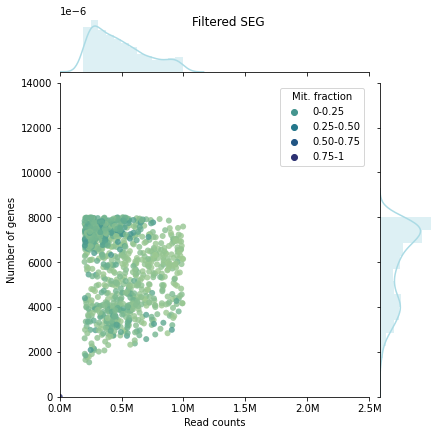

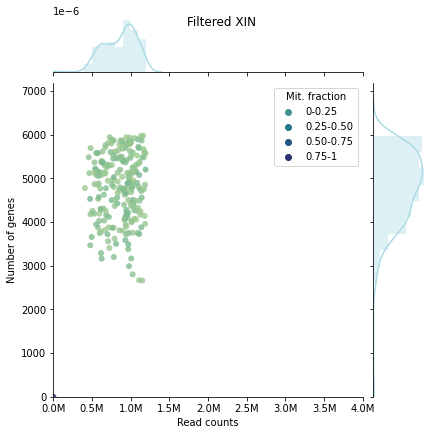

In [ ]:
g1 = jointPlot2(ad_seg_final,magnitude="M",title="Filtered SEG",
               xlim=2500000,ylim=14000,
               hist_col="#ABDBE5",palette="crest")
#plt.savefig("/content/drive/MyDrive/scPanBetaT2D-master/plots/jointPlot.SEG.pdf", transparent=True)

g2 = jointPlot2(ad_xin_final,magnitude="M",palette="crest",
               xlim=4000000,title="Filtered XIN",
               hist_col="#ABDBE5")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


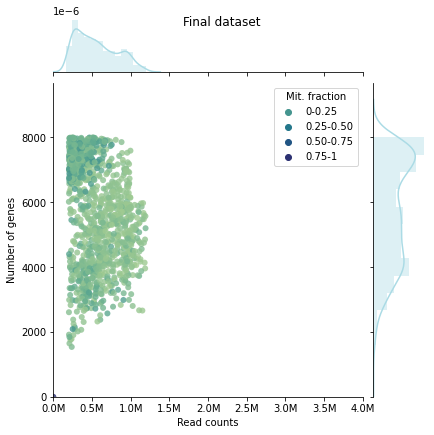

In [ ]:
g3 = jointPlot2(adata_final,magnitude="M",palette="crest",
               xlim=4000000,title="Final dataset",
               hist_col="#ABDBE5")

In [ ]:
adata_pp = adata_final.copy()
# standardize and log-transform data
# standardize counts to 10k per cell
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e4)
# Log transform data
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)

In [ ]:
adata_final = adata_pp # restore adata to its backup
sc.pp.highly_variable_genes(adata_final,n_top_genes=1700,batch_key="dataset")

In [ ]:
adata_final.var[adata_final.var["highly_variable"]]
sum(adata_final.var["highly_variable_intersection"])
hvgs = adata_final.var[adata_final.var["highly_variable_intersection"]].index.values

In [ ]:
spliced = [adata_final[adata_final.obs["dataset"]==x,:].copy() for x in ["SEG","XIN"]]
spliced[0]

In [ ]:
import mnnpy
mnn_corrected = mnnpy.mnn_correct(*spliced, 
                              var_subset=hvgs, 
                              batch_categories = ["SEG","XIN"])

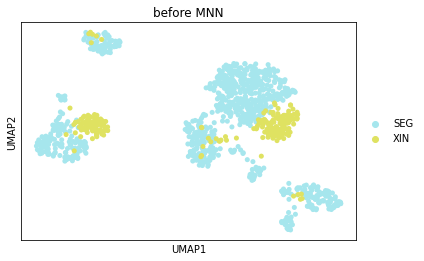

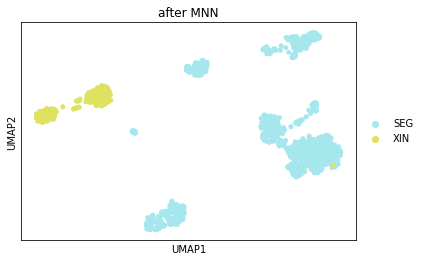

In [ ]:
# before/after MNN visualization
sc.pp.pca(adata_final)
sc.pp.neighbors(adata_final)
sc.tl.umap(adata_final)

if type(mnn_corrected) == tuple: mnn_corrected = mnn_corrected[0]
sc.pp.pca(mnn_corrected)
sc.pp.neighbors(mnn_corrected)
sc.tl.umap(mnn_corrected)

sc.pl.umap(adata_final, color='dataset',palette=['#A6E6ED','#DFE261','#9F74CE'],title="before MNN")
sc.pl.umap(mnn_corrected, color='dataset',palette=['#A6E6ED','#DFE261','#9F74CE'],title="after MNN")

In [ ]:
sc.tl.louvain(mnn_corrected,resolution=0.5)

In [ ]:
from BCBio import GFF

ens_container = {}

in_file = "/content/drive/MyDrive/scPanBetaT2D-master/input_files/ensembl/Homo_sapiens.GRCh37.87.chr_patch_hapl_scaff.gtf"

in_handle = open(in_file)
for rec in GFF.parse(in_handle):
    for f in rec.features:
        if "gene_id" not in f.qualifiers: continue
        # if len(set(f.qualifiers["gene_id"]).intersection(degs_ens_set))==0: continue
        gene_ids = f.qualifiers["gene_id"]
        for gene_id in gene_ids: ens_container[gene_id] = f.qualifiers
in_handle.close()

In [ ]:
ens_container['ENSG00000089327']

{'gene_id': ['ENSG00000089327'],
 'gene_version': ['10'],
 'gene_name': ['FXYD5'],
 'gene_source': ['ensembl_havana'],
 'gene_biotype': ['protein_coding'],
 'source': ['ensembl_havana']}

In [ ]:
# add gene name and biotype to mnn_corrected
mnn_corrected.var["gene_name"] = mnn_corrected.var.index.map(lambda x: ens_container[x]['gene_name'][0])
mnn_corrected.var["gene_biotype"] = mnn_corrected.var.index.map(lambda x: ens_container[x]['gene_biotype'][0])


In [ ]:
mnn_corrected.var.head(n=9)

,n_cells-0,n_cells-1,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,gene_name,gene_biotype
ENSG00000227232,44,6,False,0.001021,-3.585566,-1.949095,0,False,WASH7P,pseudogene
ENSG00000237683,47,13,False,0.003915,-2.044815,-1.032788,0,False,AL627309.1,protein_coding
ENSG00000241860,13,14,False,0.001461,-3.047677,-1.661938,0,False,RP11-34P13.13,processed_transcript
ENSG00000241599,5,5,False,0.000444,-3.096735,-1.672847,0,False,RP11-34P13.9,lincRNA
ENSG00000228463,17,6,False,0.003923,-1.344313,-0.635003,0,False,AP006222.2,lincRNA
ENSG00000225972,381,97,False,0.287839,1.007742,0.855173,1,False,MTND1P23,pseudogene
ENSG00000225630,946,229,False,0.875592,0.124567,-1.357127,0,False,MTND2P28,pseudogene
ENSG00000237973,936,214,False,0.683117,0.952113,0.030494,0,False,hsa-mir-6723,pseudogene
ENSG00000229344,440,195,False,0.028340,-3.154553,-1.705293,0,False,RP5-857K21.7,pseudogene


In [ ]:
sc.tl.rank_genes_groups(mnn_corrected, groupby='louvain', key_added='rank_genes')

/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


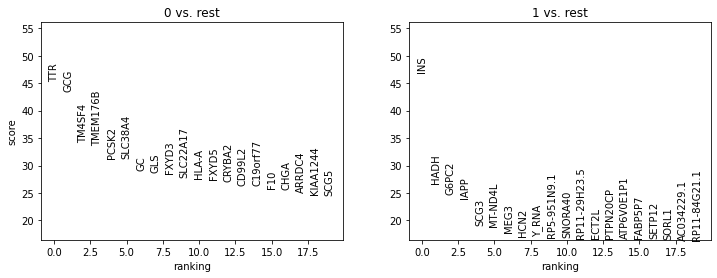

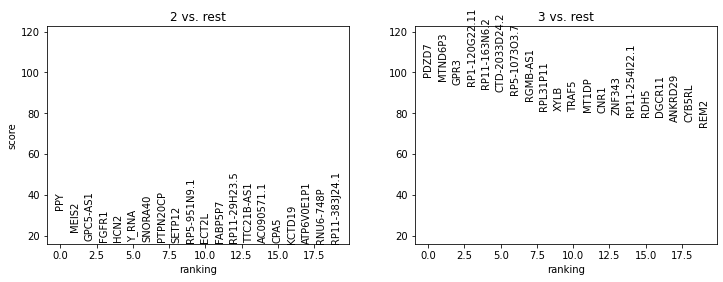

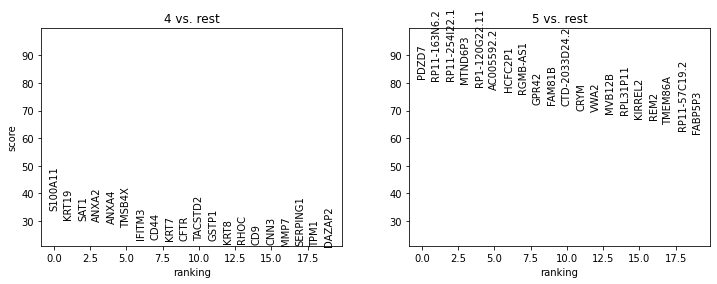

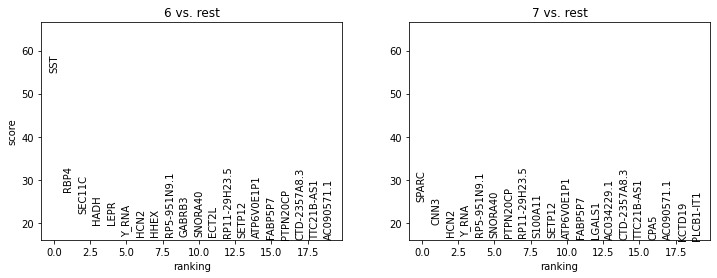

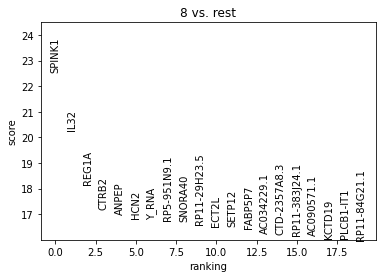

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['0','1'], fontsize=10,gene_symbols="gene_name")
# 0 -> alpha; 1 -> beta
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['2','3',], fontsize=10,gene_symbols="gene_name")
# 2 -> gamma; 3 -> ductal
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['4','5'], fontsize=10,gene_symbols="gene_name")
# 4 -> delta ; 5 -> stellate
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['6','7'], fontsize=10,gene_symbols="gene_name")
# 6 -> acinar
sc.pl.rank_genes_groups(mnn_corrected, key='rank_genes', groups=['8'], fontsize=10,gene_symbols="gene_name")


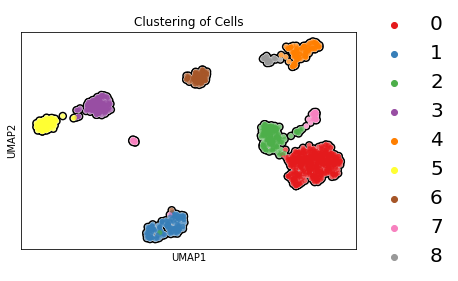

In [ ]:
palette = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#b45f06','#be697e']
fig, ax = plt.subplots(1,1)
sc.pl.umap(mnn_corrected, color='louvain', add_outline=True, legend_fontsize=20, legend_fontoutline=2,frameon=True,
               title='Clustering of Cells',ax=ax, palette='Set1')

In [ ]:
mnn_corrected.layers['scaled'] = sc.pp.scale(mnn_corrected, copy=True).X

/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


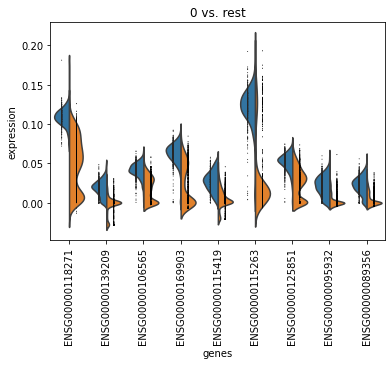

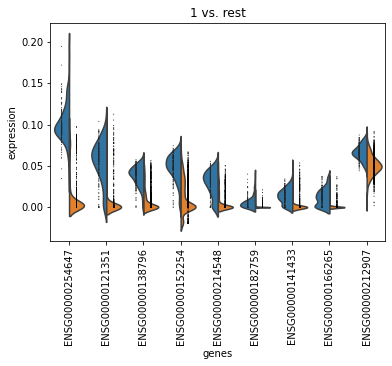

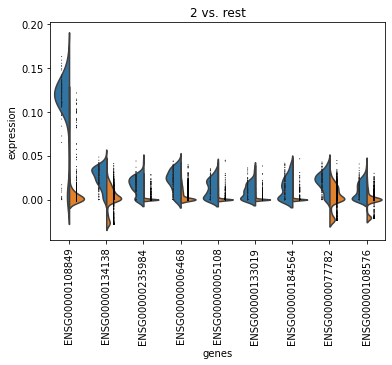

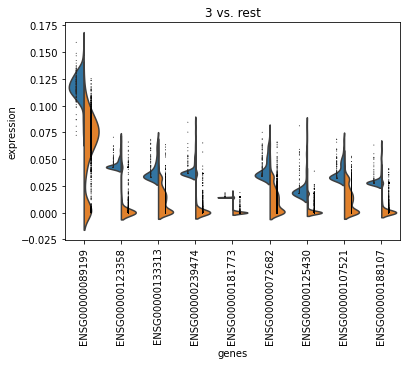

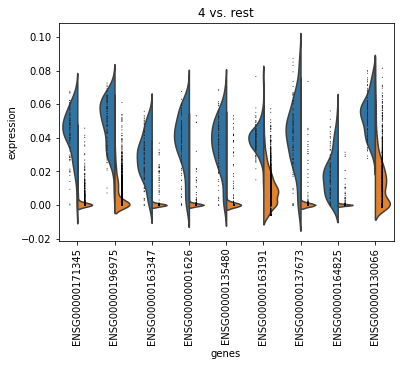

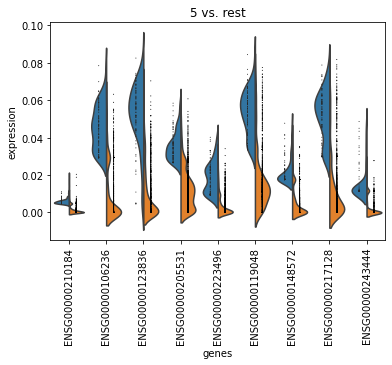

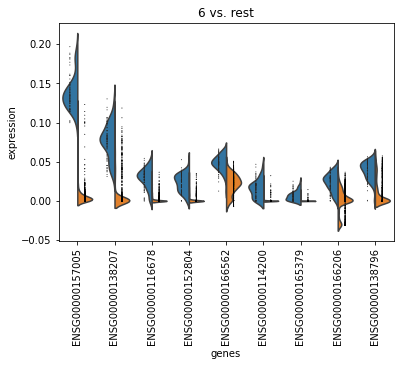

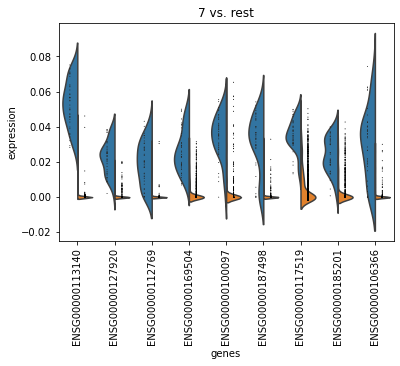

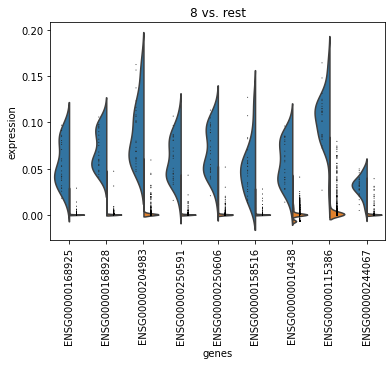

In [ ]:
sc.tl.rank_genes_groups(mnn_corrected, groupby='louvain', method='wilcoxon', key_added='rank_genes', gene_symbols = "gene_names")
sc.pl.rank_genes_groups_violin(mnn_corrected, n_genes=9, jitter=False)

In [ ]:
marker_genes = {'TTR': 'ENSG00000118271',
                 'INS': 'ENSG00000254647',
                 'PPY': 'ENSG00000108849',
                 'CHGB': 'ENSG00000089199',
                 'KRT-19': 'ENSG00000171345',
                 'MT-TS2': 'ENSG00000210184',
                 'SST': 'ENSG00000157005',
                 'SPARC': 'ENSG00000113140',
                 'CTRB1': 'ENSG00000168925'}


categories: 0, 1, 2, etc.
var_group_labels: TTR, INS, PPY, etc.


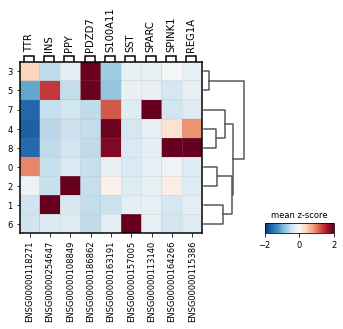

In [ ]:
sc.pl.matrixplot(mnn_corrected, marker_genes, 'louvain', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

{'heatmap_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fea08a36dd0>,
 'groupby_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fea087e0450>,
 'dendrogram_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fea08a331d0>,
 'gene_groups_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fea0874fa50>}

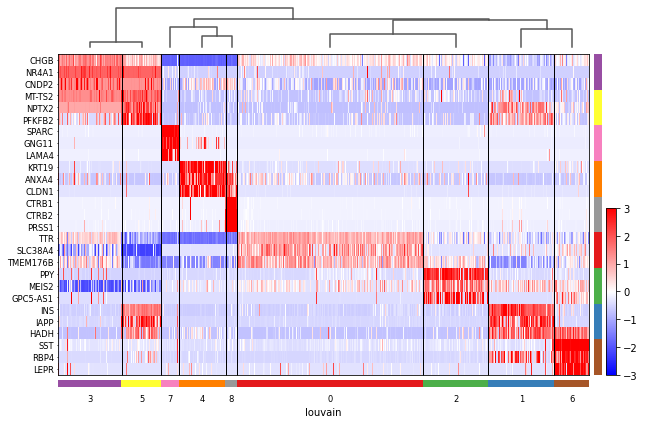

In [ ]:
sc.pl.rank_genes_groups_heatmap(mnn_corrected, key = 'rank_genes', n_genes= 3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False, gene_symbols="gene_name")